In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict

In [2]:
env = gym.make('Blackjack-v1')

print(vars(env), end='\n\n')
print(dir(env))

{'env': <StepAPICompatibility<PassiveEnvChecker<BlackjackEnv<Blackjack-v1>>>>, '_action_space': None, '_observation_space': None, '_reward_range': None, '_metadata': None, 'new_step_api': True, '_has_reset': False, '_disable_render_order_enforcing': False}

['__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_action_space', '_disable_render_order_enforcing', '_has_reset', '_is_protocol', '_metadata', '_np_random', '_observation_space', '_reward_range', 'action_space', 'class_name', 'close', 'env', 'has_reset', 'metadata', 'new_step_api', 'np_random', 'observation_space',

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
print(env.observation_space)
print(env.action_space)


Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [4]:
random_state = env.reset()
print('Random State', random_state)

random_action = env.action_space.sample()
print('Random Action', random_action)

Random State (20, 4, False)
Random Action 0


In [5]:
num_episodes = 3

for i in range(num_episodes):
    print('Episode : ', i+1)
    state = env.reset()
    step = 0
    while True:
        step +=1
        action = env.action_space.sample()
        print('Step = {}\t State = {}\t Action Taken = {}'.format(step, state, action))
        state, reward, done, info = env.step(action)
        if done:
            print('Game Ended...')
            if reward > 0: print('Agent Won!\n')
            else: print('Agent Lost!\n')
            break


Episode :  1
Step = 1	 State = (21, 1, True)	 Action Taken = 1
Step = 2	 State = (15, 1, False)	 Action Taken = 0
Game Ended...
Agent Lost!

Episode :  2
Step = 1	 State = (21, 9, True)	 Action Taken = 1
Step = 2	 State = (17, 9, False)	 Action Taken = 0
Game Ended...
Agent Lost!

Episode :  3
Step = 1	 State = (12, 10, False)	 Action Taken = 0
Game Ended...
Agent Lost!



/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [6]:
def random_policy(nA):
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

def greedy_policy(Q):
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return policy_fn

def mc_off_policy(env, num_episodes, behavior_policy, max_time=100, discount_factor=1.0):

# Set up a dictionary Q to store Q-values for state-action pairs, initialized to zeros.
# Create a dictionary C to keep track of cumulative weights for state-action pairs.
# Establish the target policy using a greedy approach based on the current Q-values.
# Episode Loop:

# Run a loop for a specified number of episodes.
# Print progress every 1000 episodes.
# Initialize an empty list to store the episode information.
# Reset the environment to get the initial state.
# Step Loop within an Episode:

# For each time step within an episode:
# Use the behavior policy to choose an action based on the current state.
# Record the state, action, and reward.
# Update the state based on the chosen action.
# Continue until the episode is finished.
# Backward Update Loop:

# Starting from the last time step of the episode:
# Calculate the return G by discounting future rewards.
# Update the cumulative weight C for the chosen state-action pair.
# Update the Q-value using the off-policy correction formula.
# If the chosen action is not recommended by the target policy, break out of the loop.
# Adjust the importance sampling weight W for the next iteration.

#INSERT UR CODE HERE
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The cumulative denominator of the weighted importance sampling formula
    # (across all episodes)
    C = defaultdict(lambda: np.zeros(env.action_space.n))

    # Our greedily policy we want to learn
    target_policy = greedy_policy(Q)

    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            # Sample an action from our policy
            probs = behavior_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Sum of discounted returns
        G = 0.0
        # The importance sampling ratio (the weights of the returns)
        W = 1.0
        # For each step in the episode, backwards
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            # Update the total reward since step t
            G = discount_factor * G + reward
            # Update weighted importance sampling formula denominator
            C[state][action] += W
            # Update the action-value function using the incremental update formula (5.7)
            # This also improves our target policy which holds a reference to Q
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            # If the action taken by the behavior policy is not the action
            # taken by the target policy the probability will be 0 and we can break
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./behavior_policy(state)[action]
    return Q, target_policy

In [7]:
random_policy = random_policy(env.action_space.n)
Q, policy = mc_off_policy(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000.

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()


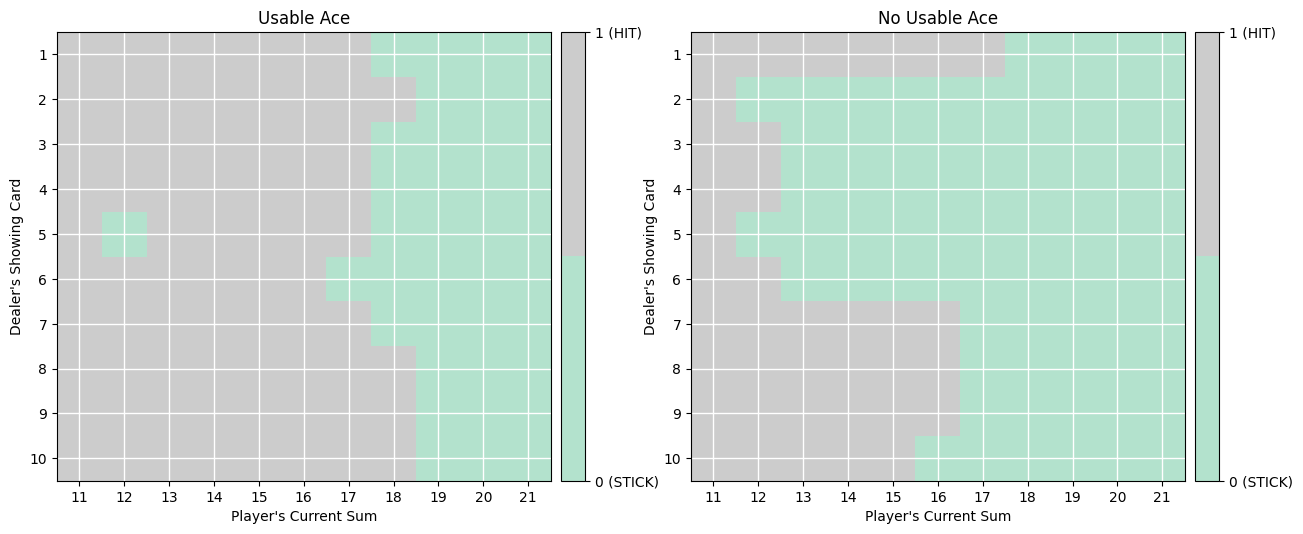

In [9]:
policy = dict((k,np.argmax(v)) for k, v in Q.items())
plot_policy(policy)